# Capstone Project: Police Call Outcome Prediction: Year 2019

This notebook explores and analyzes police call data in the city of San Jose, California, with the goal of predicting whether the outcome will be an arrest, a citation, or neither. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [2]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings, os, sys
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2019 from a CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [4]:
years = [2019]
year = "2019"

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 322624


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [8]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
92823,20190420180109PD,7632030,5/14/2021 12:00:00 AM,P191100761,6,4/20/2019 12:00:00 AM,4/20/2019 12:00:00 AM,17:57:28,1195,VEHICLE STOP,N,No report required; dispatch r,MONTEREY RD & SKYWAY DR,San Jose,CA,37.292832,-121.849796,Umbarger
125205,20190527170738PD,7681368,5/14/2021 12:00:00 AM,P191470616,2,5/27/2019 12:00:00 AM,5/27/2019 12:00:00 AM,17:04:49,415,DISTURBANCE,CAN,Canceled,NaN,San Jose,CA,NaN,NaN,NaN
285556,20191117132604PS,7924529,5/14/2021 12:00:00 AM,P193210437,3,11/17/2019 12:00:00 AM,11/17/2019 12:00:00 AM,13:02:23,1066W,SUSPICIOUS PERSON W/ WEAPON,N,No report required; dispatch r,[500]-[600] SADDLE BROOK DR,San Jose,CA,37.266243,-121.822108,Hayes
222765,20190910152706PD,7829327,5/14/2021 12:00:00 AM,P192530488,5,9/10/2019 12:00:00 AM,9/10/2019 12:00:00 AM,11:45:58,647C,OBSTRUCT STREETS OR SIDEWALK,H,Courtesy Service/Citizen or ag,STORY RD & LUCRETIA AV,San Jose,CA,37.323890,-121.857548,Little Saigon and Spring Brook
39083,20190218165715PS,7550083,5/14/2021 12:00:00 AM,P190490537,2,2/18/2019 12:00:00 AM,2/18/2019 12:00:00 AM,16:41:57,415A,"DISTURBANCE, FIGHT",N,No report required; dispatch r,[500]-[600] S 10TH ST,San Jose,CA,37.332423,-121.874599,Naglee


In [10]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322624 entries, 0 to 322623
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              322624 non-null  object 
 1   EID               322624 non-null  int64  
 2   START_DATE        322624 non-null  object 
 3   CALL_NUMBER       322624 non-null  object 
 4   PRIORITY          322624 non-null  int64  
 5   REPORT_DATE       322624 non-null  object 
 6   OFFENSE_DATE      322624 non-null  object 
 7   OFFENSE_TIME      322624 non-null  object 
 8   CALLTYPE_CODE     322624 non-null  object 
 9   CALL_TYPE         322595 non-null  object 
 10  FINAL_DISPO_CODE  322624 non-null  object 
 11  FINAL_DISPO       322624 non-null  object 
 12  ADDRESS           312772 non-null  object 
 13  CITY              322624 non-null  object 
 14  STATE             322624 non-null  object 
 15  LATITUDE          289198 non-null  float64
 16  LONGITUDE         28

In [12]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.226240e+05,322624.000000,289198.000000,289198.000000
mean,7.735770e+06,3.351204,37.320996,-121.871364
std,1.416965e+05,1.396038,0.042977,0.047529
min,7.488585e+06,1.000000,37.150332,-122.035696
25%,7.613608e+06,2.000000,37.296855,-121.902506
50%,7.735370e+06,3.000000,37.324518,-121.869361
75%,7.858678e+06,4.000000,37.349085,-121.838813
max,7.981562e+06,6.000000,37.539229,-121.660052


In [14]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,322624,322624,322624,322624,322624,322624,322624,322595,322624,322624,312772,322624,322624,287684
unique,320487,1,316239,365,365,81098,209,202,22,18,31954,1,1,295
top,20191025203250PD,5/14/2021 12:00:00 AM,P192660947,8/23/2019 12:00:00 AM,8/23/2019 12:00:00 AM,22:37:21,415,DISTURBANCE,N,No report required; dispatch r,[200]-[300] W MISSION ST,San Jose,CA,Spartan Keyes and Wool Creek
freq,3,322624,5,1100,1100,16,30260,30258,146755,146755,1744,322624,322624,8536


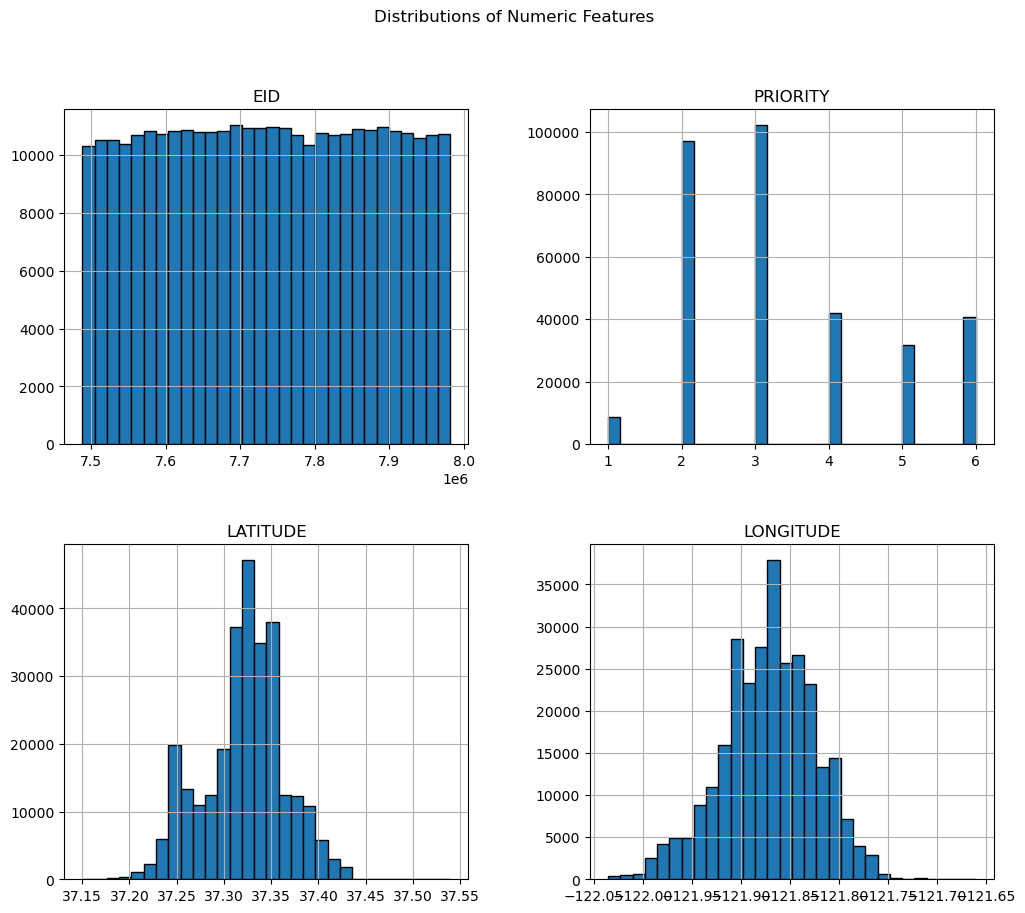

In [15]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [18]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE              29
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              9852
CITY                    0
STATE                   0
LATITUDE            33426
LONGITUDE           33426
neighborhood        34940
dtype: int64

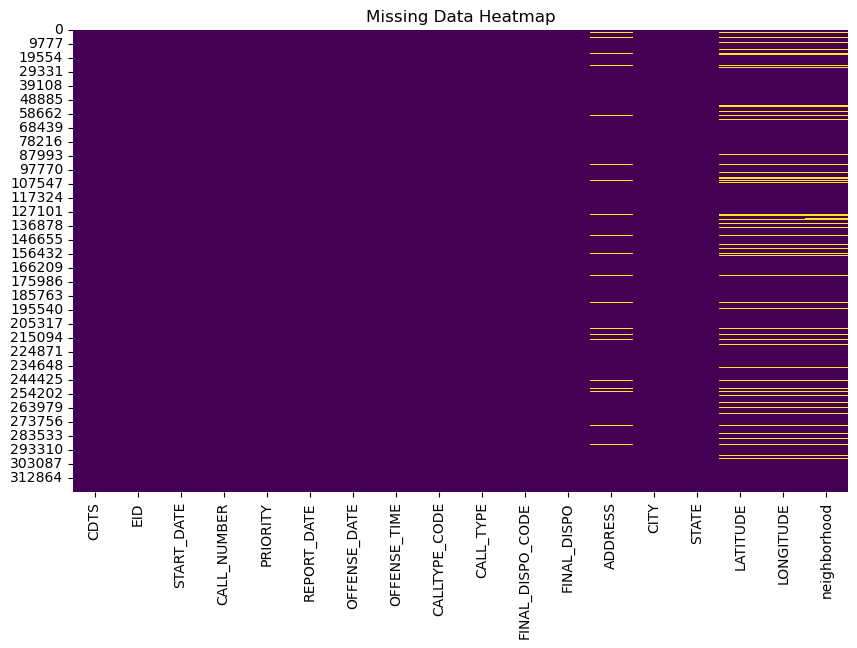

In [20]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [21]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 320487 unique values
START_DATE: 1 unique values
CALL_NUMBER: 316239 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 81098 unique values
CALLTYPE_CODE: 209 unique values
CALL_TYPE: 202 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 31954 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [22]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8536
Little Saigon and Spring Brook    5459
Trimble Business Area             4858
Fruitdale and Sherman Oaks        4777
Five Wounds-San Jose High         4721
                                  ... 
Los Alamitos Creek                  48
Linda Vista and Hillcrest           36
Meadowlands                         36
Alta Vista                          31
Santa Teresa Hills                  26
Name: count, Length: 295, dtype: int64

In [23]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          146755
CAN         46827
R           37038
G           20111
E           13928
D           10053
A            7225
U            5690
O            5291
DUPNCAN      5208
GD           4427
C            4214
H            3767
ADV          3279
B            3226
T            3079
NR           1305
F             949
M              86
Z              62
P              62
TOT            42
Name: count, dtype: int64

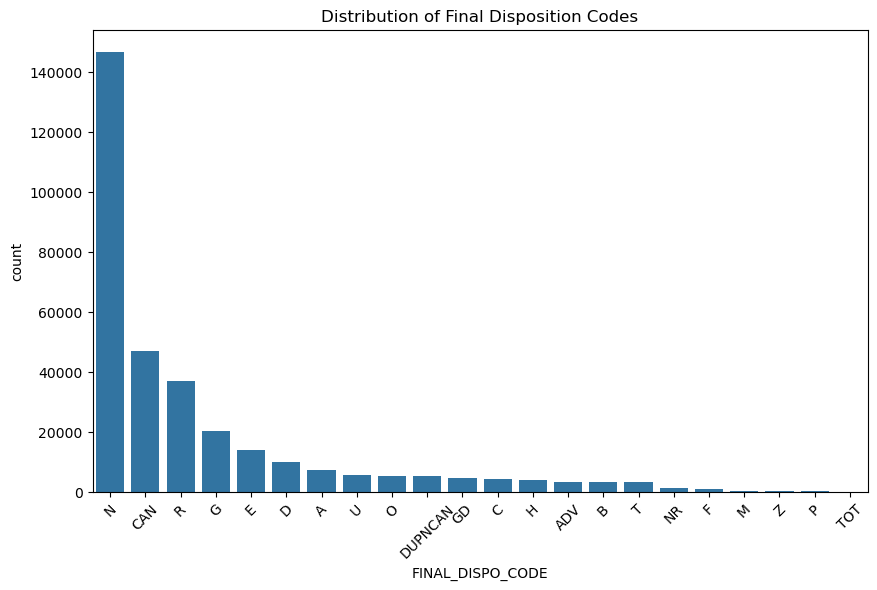

In [25]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [30]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    146755
Canceled                           46827
Report taken                       37038
Gone on Arrival/unable to loca     20111
Traffic Citation Issued, Non-H     13928
No Disposition                     13018
Traffic Citation Issued, Hazar     10053
Arrest Made                         7225
Unfounded event                     5690
Supplemental report taken           5291
Criminal Citation                   4214
Courtesy Service/Citizen or ag      3767
Arrest by Warrant                   3226
Turned over To (TOT)                3079
No Response                         1305
Field Interview (F.I.) Complet       949
Stranded motorist assist              86
Prior case, follow-up activity        62
Name: count, dtype: int64

In [32]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'CAN': 'Canceled',
 'N': 'No report required; dispatch r',
 'DUPNCAN': 'No Disposition',
 'NR': 'No Response',
 'G': 'Gone on Arrival/unable to loca',
 'R': 'Report taken',
 'T': 'Turned over To (TOT)',
 'GD': 'No Disposition',
 'U': 'Unfounded event',
 'H': 'Courtesy Service/Citizen or ag',
 'E': 'Traffic Citation Issued, Non-H',
 'A': 'Arrest Made',
 'F': 'Field Interview (F.I.) Complet',
 'O': 'Supplemental report taken',
 'C': 'Criminal Citation',
 'B': 'Arrest by Warrant',
 'D': 'Traffic Citation Issued, Hazar',
 'ADV': 'No Disposition',
 'Z': 'No Disposition',
 'TOT': 'No Disposition',
 'M': 'Stranded motorist assist',
 'P': 'Prior case, follow-up activity'}

In [34]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'1057': 'FIREARMS DISCHARGED',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '1066': 'SUSPICIOUS PERSON',
 '415F': 'DISTURBANCE, FAMILY',
 '242': 'BATTERY',
 '415': 'DISTURBANCE',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '415M': 'DISTURBANCE, MUSIC',
 '1033A': 'ALARM, AUDIBLE',
 '415A': 'DISTURBANCE, FIGHT',
 '602PC': 'TRESPASSING',
 '1154': 'SUSPICIOUS VEHICLE',
 '415N': 'DISTURBANCE, NEIGHBOR',
 '415EMS': 'DISTURBANCE (COMBINED EVENT)',
 'WELCK': 'WELFARE CHECK',
 '1070': 'PROWLER',
 '5150X': 'MENTALLY DISTURBED FEMALE',
 '10851': 'STOLEN VEHICLE',
 'FDAID': 'FIRE DEPARTMENT REQUEST FOR PD',
 'WELCKEMS': 'WELFARE CHECK (COMBINED EVENT)',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '5150': 'MENTALLY DISTURBED PERSON',
 '459R': 'BURGLARY  REPORT  (460)',
 '23103': 'RECKLESS DRIVING',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAM',
 '594': 'MALICIOUS MISCHIEF',
 '242EMS': 'BATTERY (COMBINED EVENT)',
 '459': 'BURGLARY (460)',
 '911UNK': 'UNK TYPE 911 CALL',
 '415FEMS': 'DISTURBANCE, FAMILY (COMBINED ',
 '106

## Focus on Target Dispositions

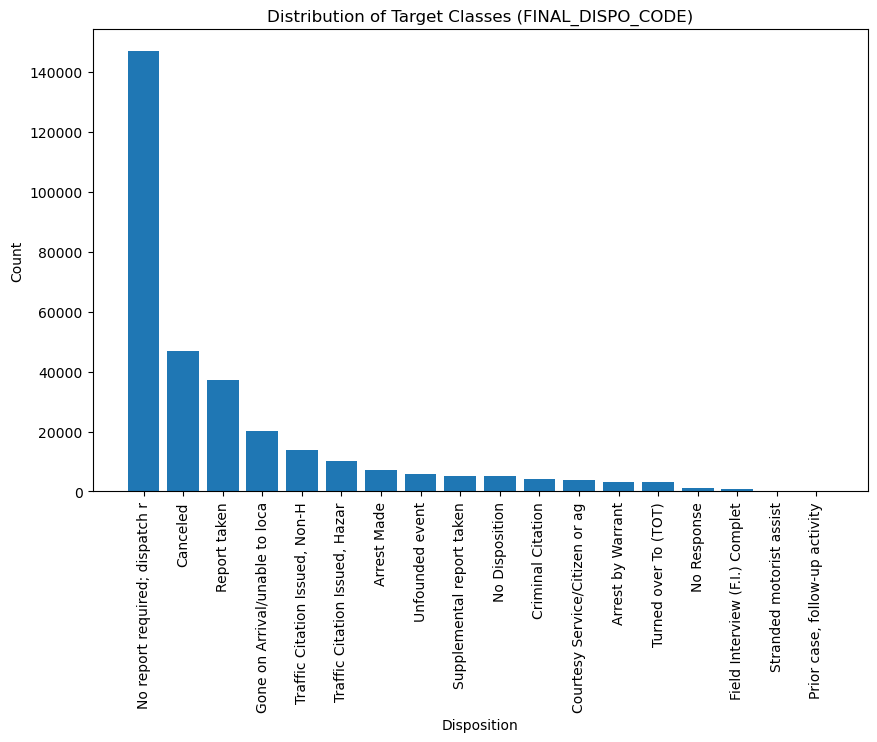

In [37]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [39]:
model_utils.transform_offense_date(all_police_df)

In [41]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    307959
A          7225
C          4214
B          3226
Name: count, dtype: int64

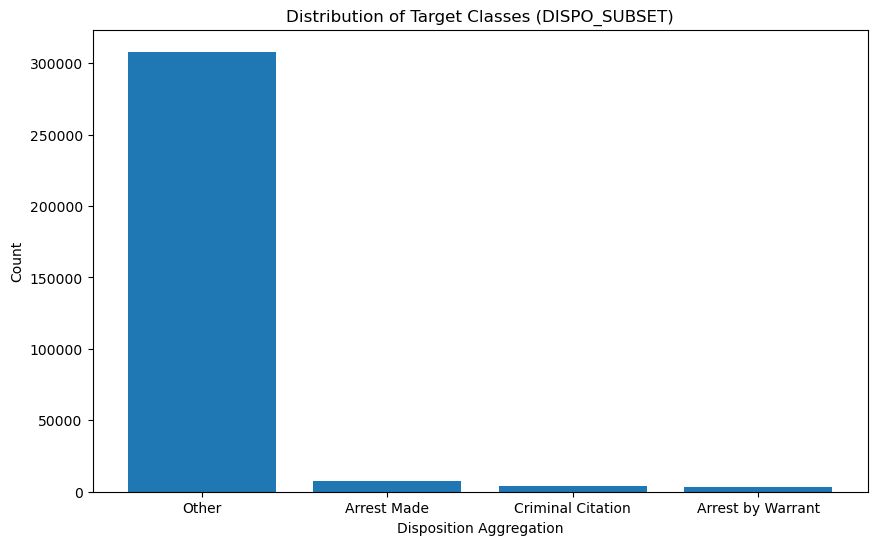

In [43]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.savefig('images/class_imbalance.png')
plt.show()

## Data Cleaning and Feature Engineering

In [46]:
police_calls_encoded = model_utils.clean_and_transform_data(all_police_df)

Police Calls Dataset: 322624 rows before cleaning, 287658 rows after cleaning.


In [48]:
police_calls_encoded.shape

(287658, 15)

In [50]:
police_calls_encoded

,PRIORITY,CALLTYPE_CODE,LATITUDE,LONGITUDE,neighborhood,OFFENSE_HOUR,OFFENSE_DAY_OF_WEEK,OFFENSE_MONTH,OFFENSE_YEAR,AFTER_COVID,DISPO_SUBSET,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2
0,2,1057,0.338096,0.753943,Hillview,0,1,1,2019,No,Other,0.051047,0.114309,0.254905,0.568429
1,4,415FC,-1.697860,-0.907054,Lone Hill,0,1,1,2019,No,Other,0.094253,2.882727,1.540050,0.822746
3,2,415FC,0.650033,0.605739,Mayfair,0,1,1,2019,No,Other,0.045244,0.422543,0.393751,0.366920
4,4,415FC,-1.565161,-0.849697,Branham,0,1,1,2019,No,Other,0.088016,2.449728,1.329913,0.721985
5,4,415FC,-0.609370,-0.808761,Willow Glen West,0,1,1,2019,No,Other,0.049083,0.371332,0.492835,0.654095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322618,2,415,1.521992,-0.927762,Trimble Business Area,0,1,12,2019,No,Other,0.055960,2.316461,-1.412046,0.860742
322619,3,1033A,0.142512,1.415242,The Glens,0,1,12,2019,No,Other,0.083002,0.020310,0.201689,2.002910
322620,4,22500,0.537381,0.129704,Bonita Park,0,1,12,2019,No,Other,0.022230,0.288778,0.069700,0.016823
322622,4,22500,0.815252,0.892475,Lyndale,0,1,12,2019,No,Other,0.060211,0.664637,0.727593,0.796512


## Define X and Y

In [53]:
# load the encoder file
encoder = joblib.load('one_hot_encoder.pkl')

In [55]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled, _ = \
    model_utils.split_data(police_calls_encoded, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(230126, 14)
(57532, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 219616, 0: 5234, 2: 2982, 1: 2294})
Counter({3: 10510, 0: 5234, 2: 2982, 1: 2294})


In [56]:
X_train.shape

(230126, 529)

In [57]:
X_train

,PRIORITY,LATITUDE,LONGITUDE,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2,CALLTYPE_CODE_1033,CALLTYPE_CODE_1033A,CALLTYPE_CODE_1033CTX,...,neighborhood_Willow Glen South,neighborhood_Willow Glen West,neighborhood_Willow Vale,neighborhood_Willowmont,neighborhood_Winchester,neighborhood_Winchester Lynnhaven,neighborhood_Windmill Springs,neighborhood_Wooster and East Ct and West Ct,neighborhood_YB Lucretia,AFTER_COVID_Yes
112663,-0.975463,0.176476,1.194278,0.400237,-0.709531,0.343169,0.290582,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155499,1.889338,0.325788,1.509294,0.821173,-0.654752,0.604216,0.875173,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227041,0.456938,1.564526,-0.032070,-0.206165,1.058639,0.099208,-0.686362,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270804,-0.975463,0.092602,-0.850223,-0.897099,-0.725982,0.075044,-0.188751,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192369,-0.259263,-0.580821,-0.776958,-0.335960,-0.484669,0.569063,-0.270812,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164458,-0.259263,-1.634833,-1.627081,1.419187,1.226129,2.626139,1.135167,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172499,-0.975463,0.803080,1.231841,0.491917,-0.260671,1.066708,0.353128,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184671,0.456938,0.634371,-0.667614,-1.165995,-0.438085,-0.246594,-0.379562,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68060,-0.259263,1.206306,0.591640,-0.101361,0.332215,0.810115,-0.447770,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


y_train distribution: Counter({3: 219616, 0: 5234, 2: 2982, 1: 2294})
y_test distribution: Counter({3: 54904, 0: 1309, 2: 746, 1: 573})
y_train_resampled distribution: Counter({3: 219616, 0: 5234, 2: 2982, 1: 2294})


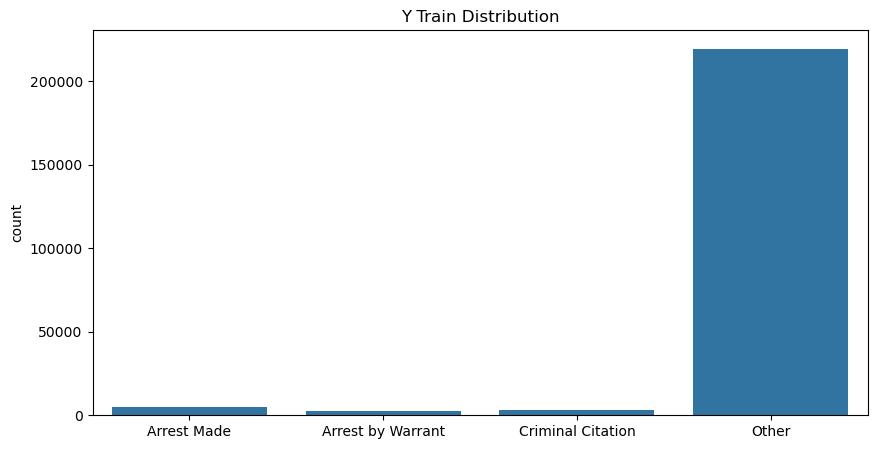

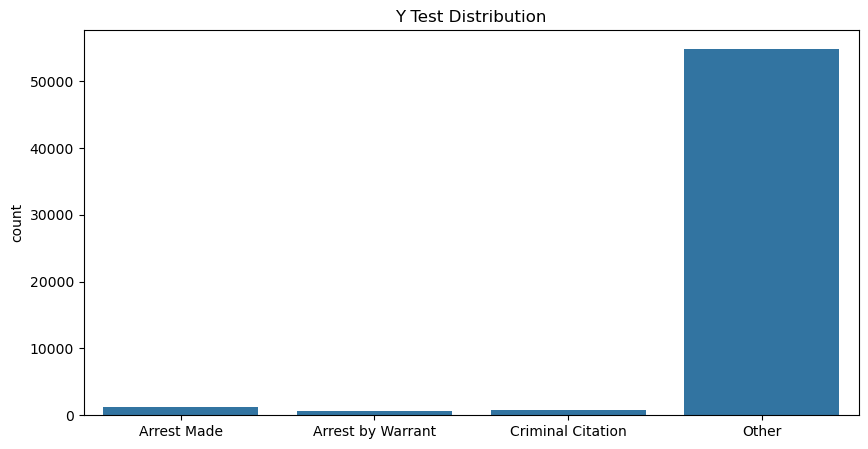

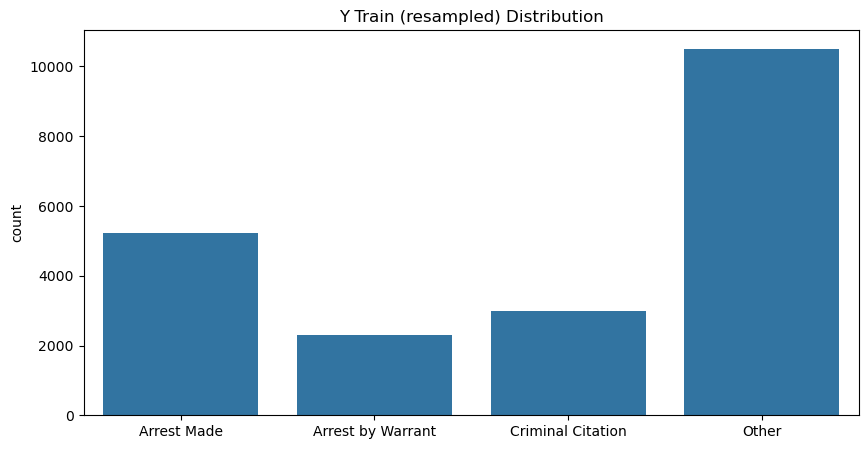

In [61]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [65]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [67]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [69]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00      1309
Arrest by Warrant       0.00      0.00      0.00       573
Criminal Citation       0.00      0.00      0.00       746
            Other       0.95      1.00      0.98     54904

         accuracy                           0.95     57532
        macro avg       0.24      0.25      0.24     57532
     weighted avg       0.91      0.95      0.93     57532



### Logistic Regression

In [72]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [73]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [74]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.19      0.59      0.28      1309
Arrest by Warrant       0.49      0.64      0.56       573
Criminal Citation       0.18      0.59      0.28       746
            Other       0.99      0.90      0.94     54904

         accuracy                           0.89     57532
        macro avg       0.46      0.68      0.51     57532
     weighted avg       0.95      0.89      0.92     57532



#### Hyperparameter Tuning

In [76]:
grid_search_scoring_method = 'f1_macro'

In [77]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

grid_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=param_grid_lr, 
                              cv=5, n_jobs=2, verbose=1, scoring=grid_search_scoring_method)

grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=2, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [78]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 10}
Best Score (f1_macro): 0.5941


In [79]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2019/best_logistic_regression.pkl']

In [84]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [85]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.60      0.32      0.41      1309
Arrest by Warrant       0.71      0.61      0.66       573
Criminal Citation       0.47      0.26      0.33       746
            Other       0.97      0.99      0.98     54904

         accuracy                           0.96     57532
        macro avg       0.69      0.54      0.60     57532
     weighted avg       0.96      0.96      0.96     57532



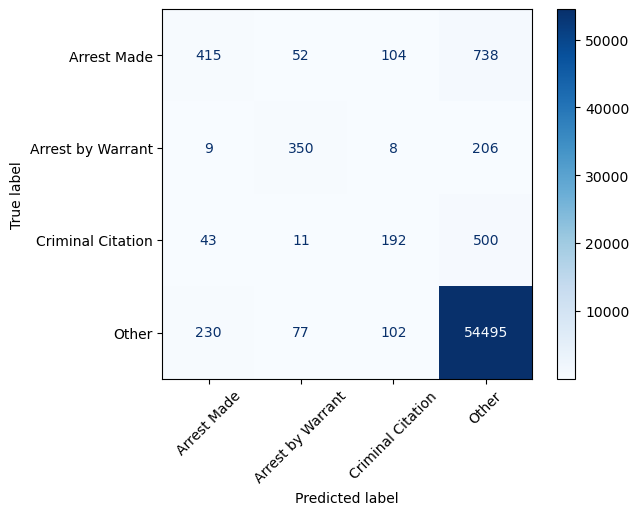

In [86]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [88]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [89]:
# Create a DataFrame to store the feature importance results
importance_df = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance_mean': permutation_importance_result.importances_mean
})

# Define a mapping of one-hot encoded columns to their original categorical feature
# This is a dictionary where keys are the original feature names, and values are lists of one-hot encoded columns
one_hot_mapping = {
    'CALLTYPE_CODE': [col for col in X_test_sample.columns if col.startswith("CALLTYPE_CODE_")],
    'neighborhood': [col for col in X_test_sample.columns if col.startswith("neighborhood_")]
}

# Initialize a list to store aggregated and non-one-hot encoded features
final_importance = []

# 1. Aggregate the importance for one-hot encoded features
for original_feature, encoded_columns in one_hot_mapping.items():
    # Sum the importance of the one-hot encoded columns for this feature
    aggregated_importance = importance_df.loc[importance_df['feature'].isin(encoded_columns), 'importance_mean'].sum()
    final_importance.append({
        'feature': original_feature,
        'importance_mean': aggregated_importance
    })

# 2. Add the importance of the non-one-hot encoded features
# Find columns that are not part of the one-hot encoded mappings
all_one_hot_encoded_columns = [col for sublist in one_hot_mapping.values() for col in sublist]
non_one_hot_encoded_features = importance_df.loc[~importance_df['feature'].isin(all_one_hot_encoded_columns)]

# Append non-one-hot encoded features' importance to the final list
for _, row in non_one_hot_encoded_features.iterrows():
    final_importance.append({
        'feature': row['feature'],
        'importance_mean': row['importance_mean']
    })

# Convert final importance list to a DataFrame
final_importance_df = pd.DataFrame(final_importance)

# Sort by importance for easier interpretation
final_importance_df = final_importance_df.sort_values(by='importance_mean', ascending=False)

In [90]:
# Use display to see the dataframe nicely formatted
from IPython.display import display
display(final_importance_df)

,feature,importance_mean
0,CALLTYPE_CODE,0.026102
5,DISTANCE_FROM_CENTER,0.000261
2,PRIORITY,0.000232
9,AFTER_COVID_Yes,0.000000
6,LATITUDE^2,-0.000058
3,LATITUDE,-0.000377
7,LATITUDE LONGITUDE,-0.000464
8,LONGITUDE^2,-0.000464
4,LONGITUDE,-0.000492
1,neighborhood,-0.001333


In [91]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [92]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                       Feature  Importance  \
200                           CALLTYPE_CODE_6M    0.007590   
199                           CALLTYPE_CODE_6F    0.002520   
184                         CALLTYPE_CODE_601T    0.002405   
59                         CALLTYPE_CODE_11300    0.001825   
64                         CALLTYPE_CODE_11377    0.000898   
8                          CALLTYPE_CODE_1033A    0.000840   
80                         CALLTYPE_CODE_12020    0.000840   
84                         CALLTYPE_CODE_14601    0.000811   
206                       CALLTYPE_CODE_911UNK    0.000492   
136                          CALLTYPE_CODE_415    0.000492   
61                         CALLTYPE_CODE_11350    0.000435   
75                          CALLTYPE_CODE_1195    0.000435   
107                        CALLTYPE_CODE_23152    0.000406   
86                           CALLTYPE_CODE_148    0.000377   
148                         CALLTYPE_CODE_415M    0.000348   
90      

In [93]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                  Display Name  Coefficient
184                   Call Type: TRUANT (TABS)     3.486537
196                 Call Type: DRUNK IN PUBLIC     2.811110
82      Call Type: CARRYING A CONCEALED WEAPON     2.689454
107                 Call Type: MISDEMEANOR DUI     2.593740
87   Call Type: RESISTING ARREST, GANG RELATED     2.495469
102               Call Type: PARKING VIOLATION    -2.378661
81    Call Type: ILLEGAL WEAPONS, GANG RELATED     2.302936
86                 Call Type: RESISTING ARREST     2.229235
80                  Call Type: ILLEGAL WEAPONS     2.142609
8                    Call Type: ALARM, AUDIBLE    -2.016143
108                      Call Type: FELONY DUI     1.936789
76           Call Type: VEHICLE STOP ON FEMALE    -1.903352
225   Call Type: VIOLATION OF PROTECTIVE ORDER     1.896004
83                Call Type: UNLICENSED DRIVER    -1.868585
206               Call Type: UNK TYPE 911 CALL    -1.857088
148              Ca

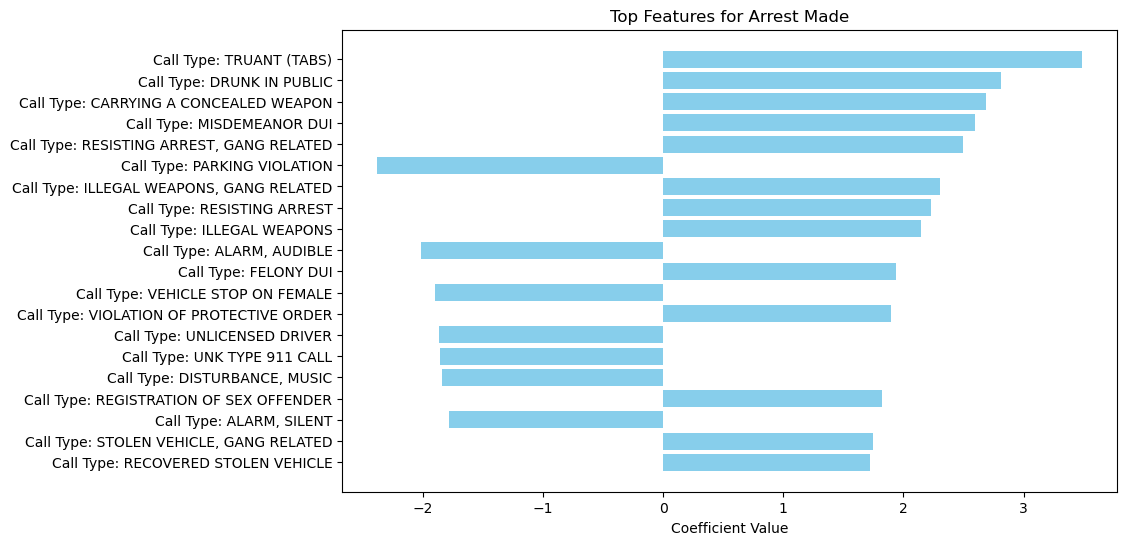

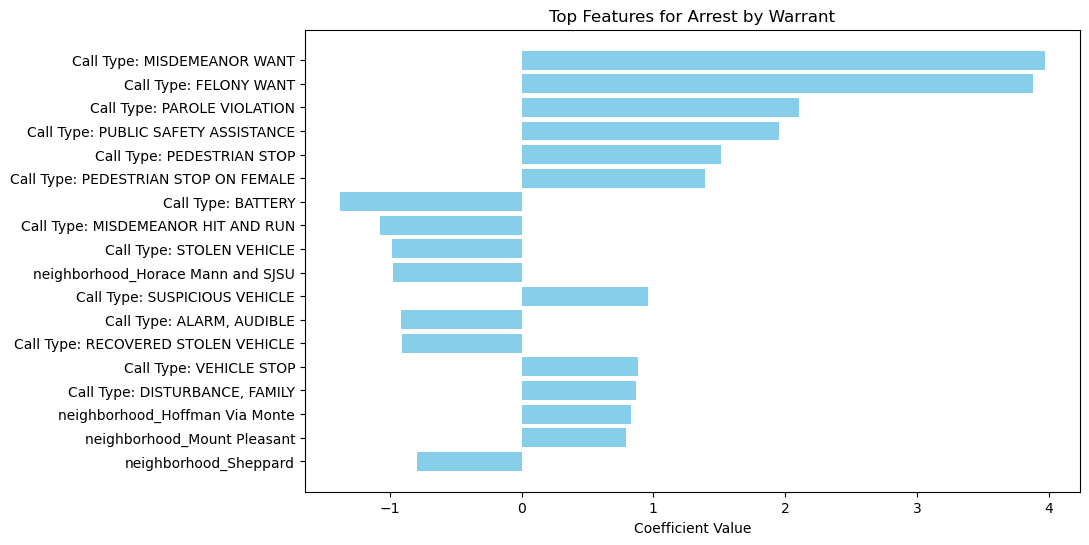

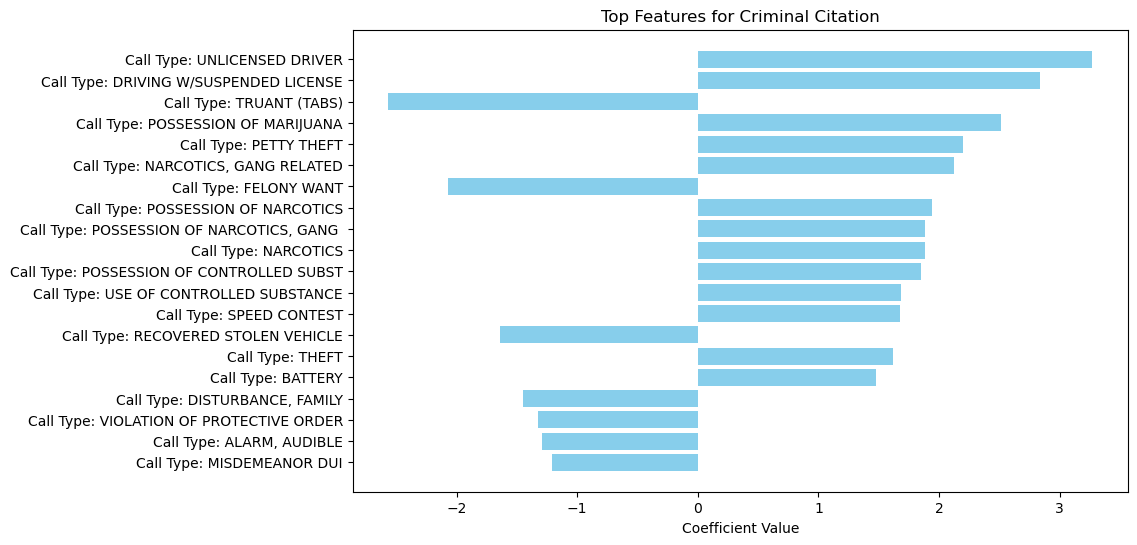

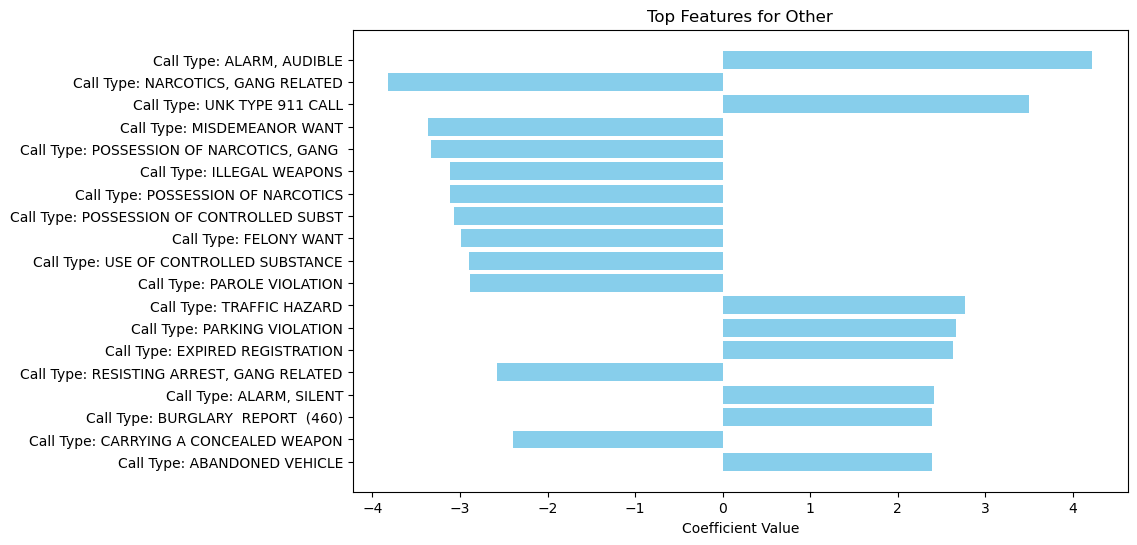

In [94]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [96]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [97]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.52      0.32      0.40      1309
Arrest by Warrant       0.66      0.51      0.58       573
Criminal Citation       0.42      0.24      0.30       746
            Other       0.97      0.99      0.98     54904

         accuracy                           0.96     57532
        macro avg       0.64      0.52      0.57     57532
     weighted avg       0.95      0.96      0.96     57532



#### Hyperparameter Tuning and Cross Validation

In [99]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=-1,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 50}
Best Score (f1_macro): 0.56


In [100]:
best_rf = grid_rf.best_estimator_

In [101]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2019/best_random_forest.pkl']

In [102]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [103]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.52      0.33      0.41      1309
Arrest by Warrant       0.67      0.52      0.58       573
Criminal Citation       0.41      0.23      0.29       746
            Other       0.97      0.99      0.98     54904

         accuracy                           0.96     57532
        macro avg       0.64      0.52      0.57     57532
     weighted avg       0.95      0.96      0.96     57532



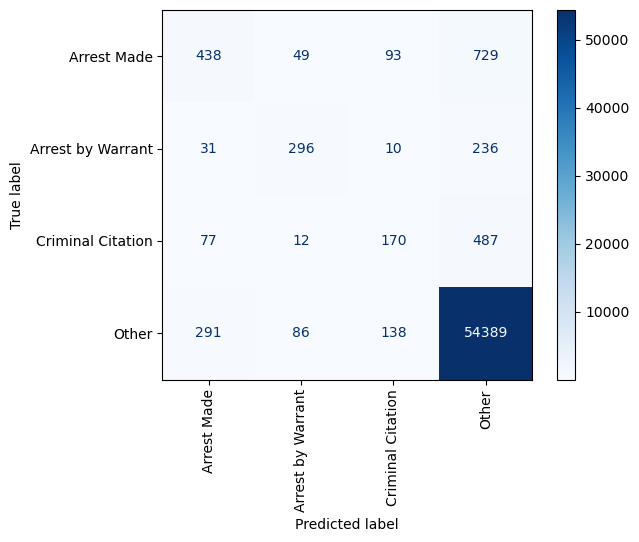

In [104]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

plt.show()

In [105]:
#### Optuna

def rf_objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize RandomForest with suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro').mean()
    return score

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-10-08 12:36:19,844] A new study created in memory with name: no-name-2fadcc3b-dcaf-47c8-9467-a010412fca48
[I 2024-10-08 12:36:21,087] Trial 0 finished with value: 0.6048819759643245 and parameters: {'n_estimators': 100, 'max_depth': 61, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.6048819759643245.
[I 2024-10-08 12:36:22,411] Trial 1 finished with value: 0.664435563373722 and parameters: {'n_estimators': 94, 'max_depth': 69, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.664435563373722.
[I 2024-10-08 12:36:23,396] Trial 2 finished with value: 0.6132486496892413 and parameters: {'n_estimators': 75, 'max_depth': 61, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.664435563373722.
[I 2024-10-08 12:36:24,394] Trial 3 finished with value: 0.6398409994024028 and parameters: {'n_estimators': 61, 'max_depth': 43, 'min_

Best hyperparameters: {'n_estimators': 100, 'max_depth': 83, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


In [106]:
best_params = study.best_params
best_params

{'n_estimators': 100,
 'max_depth': 83,
 'min_samples_split': 20,
 'min_samples_leaf': 3,
 'max_features': 'sqrt'}

In [107]:
# Train the RandomForest using the best hyperparameters
best_rf_2 = RandomForestClassifier(**best_params, n_jobs=-1)
best_rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=83, min_samples_leaf=3, min_samples_split=20,
                       n_jobs=-1)

In [108]:
# Use the best estimator to make predictions
y_pred_best_rf_2 = best_rf_2.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf_2, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.66      0.28      0.40      1309
Arrest by Warrant       0.71      0.62      0.66       573
Criminal Citation       0.51      0.23      0.31       746
            Other       0.97      0.99      0.98     54904

         accuracy                           0.96     57532
        macro avg       0.71      0.53      0.59     57532
     weighted avg       0.96      0.96      0.96     57532



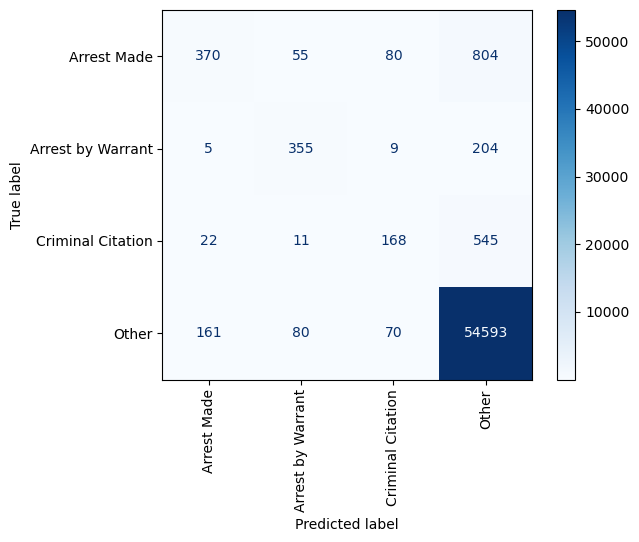

In [109]:
ConfusionMatrixDisplay.from_estimator(best_rf_2, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

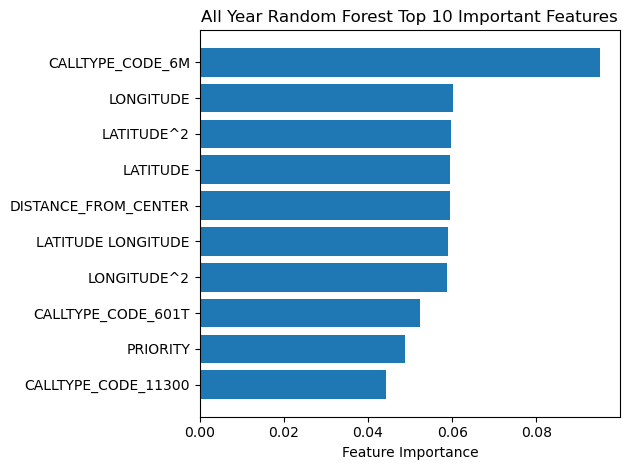

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('All Year Random Forest Top 10 Important Features')
plt.tight_layout()  # Adjusts the padding automatically
plt.savefig('images/all_year_random_forest_feature_importance.png')
plt.show()

### Multilayer Perceptron Model

In [113]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [114]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [115]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9576 - loss: 0.1813 - val_accuracy: 0.9638 - val_loss: 0.1387
Epoch 2/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9627 - loss: 0.1349 - val_accuracy: 0.9642 - val_loss: 0.1311
Epoch 3/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9632 - loss: 0.1317 - val_accuracy: 0.9646 - val_loss: 0.1301
Epoch 4/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9655 - loss: 0.1242 - val_accuracy: 0.9642 - val_loss: 0.1299
Epoch 5/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9658 - loss: 0.1210 - val_accuracy: 0.9642 - val_loss: 0.1318
Epoch 6/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9653 - loss: 0.1196 - val_accuracy: 0.9636 - val_loss: 0.1356
Epoch 7/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9665 - loss: 0.1156 - val_accuracy: 0.9634 - val_loss: 0.1390


In [116]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2019/mlp_model.pkl']

In [117]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [118]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1798/1798 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - accuracy: 0.9654 - loss: 0.1286
Test Accuracy: 0.9650


In [119]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1798/1798 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.61      0.37      0.46      1309
Arrest by Warrant       0.71      0.58      0.64       573
Criminal Citation       0.54      0.28      0.37       746
            Other       0.98      0.99      0.98     54904

         accuracy                           0.97     57532
        macro avg       0.71      0.56      0.61     57532
     weighted avg       0.96      0.97      0.96     57532



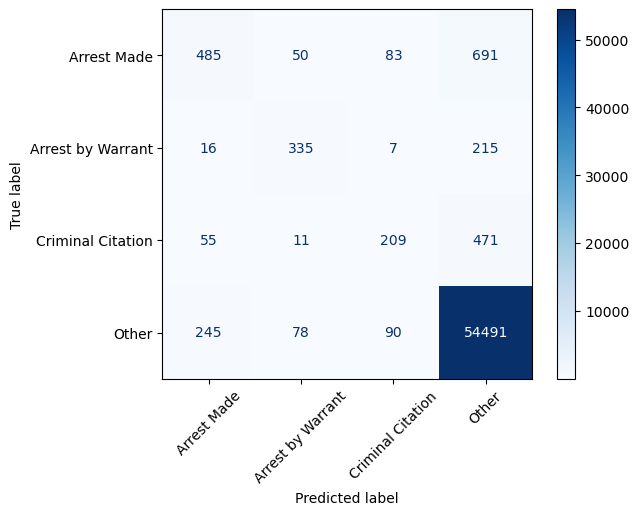

In [120]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [123]:
def objective(trial):
    params = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-08 12:38:05,441] A new study created in memory with name: no-name-dfe9aa61-8061-4ed6-adb8-3c38e8edc63b
[I 2024-10-08 12:38:26,760] Trial 0 finished with value: 0.6198062303131444 and parameters: {'learning_rate': 0.0012634666147185254, 'max_depth': 5, 'subsample': 0.8508863635081295, 'colsample_bytree': 0.8185390565416812, 'gamma': 2.4790253593264394e-06, 'reg_alpha': 4.251160998189156e-07, 'reg_lambda': 0.33824032072525007}. Best is trial 0 with value: 0.6198062303131444.
[I 2024-10-08 12:38:52,581] Trial 1 finished with value: 0.6311193570380956 and parameters: {'learning_rate': 0.0011555057436347497, 'max_depth': 7, 'subsample': 0.8634866541934301, 'colsample_bytree': 0.7440566988991638, 'gamma': 2.5818984485284093e-06, 'reg_alpha': 0.058735680416876455, 'reg_lambda': 0.0012756066115560821}. Best is trial 1 with value: 0.6311193570380956.
[I 2024-10-08 12:39:07,856] Trial 2 finished with value: 0.6968538064038163 and parameters: {'learning_rate': 0.205821722227989, 'max_d

Actual runtime: 464.90 seconds (7.75 minutes)
Best parameters found:  {'learning_rate': 0.205821722227989, 'max_depth': 3, 'subsample': 0.9008006683305574, 'colsample_bytree': 0.9815768392592749, 'gamma': 3.0831557647795984e-08, 'reg_alpha': 2.9200335261315746e-06, 'reg_lambda': 9.481845955382743e-08}
Best F1 macro score:  0.6968538064038163


In [124]:
# train the final model with the best parameters:
best_params = study.best_params
xgb_1_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_1_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9815768392592749, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=3.0831557647795984e-08, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.205821722227989, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [125]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.67      0.29      0.40      1309
Arrest by Warrant       0.71      0.62      0.66       573
Criminal Citation       0.54      0.26      0.35       746
            Other       0.97      0.99      0.98     54904

         accuracy                           0.96     57532
        macro avg       0.72      0.54      0.60     57532
     weighted avg       0.96      0.96      0.96     57532



In [126]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2019/xgb_model.pkl']

In [127]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [129]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [130]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.5972220897156718
RF F1: 0.5667450964539757
XGB F1: 0.5991826802679414


In [131]:
best_lr

LogisticRegression(C=10, max_iter=1000, random_state=42)

In [132]:
best_rf

RandomForestClassifier(n_estimators=50)

In [133]:
best_xg

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9815768392592749, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=3.0831557647795984e-08, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.205821722227989, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [134]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

base_estimators_fitted = [best_lr, best_rf, best_xg]

In [135]:
X_train_float = X_train.astype('float64')

In [136]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=2)
stacking_clf_2.fit(X_train_float, y_train)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9815768392592749,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              e...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=2)

In [137]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2019/stacking_2.pkl']

In [138]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [139]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.6198056836774518


In [140]:
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stacking_2, zero_division=0, target_names=label_names))

Ensemble Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.61      0.38      0.47      1309
Arrest by Warrant       0.70      0.59      0.64       573
Criminal Citation       0.50      0.31      0.39       746
            Other       0.98      0.99      0.98     54904

         accuracy                           0.97     57532
        macro avg       0.70      0.57      0.62     57532
     weighted avg       0.96      0.97      0.96     57532



## Results

In [142]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Ensemble'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.954321,0.250000,0.238580,0.244157
Logistic Regression,0.963846,0.544445,0.689197,0.597222
Random Forest,0.961083,0.517422,0.644773,0.566745
MLP,0.965028,0.556948,0.706218,0.612940
XGB,0.964872,0.539746,0.722928,0.599183
Ensemble,0.965150,0.568708,0.698042,0.619806


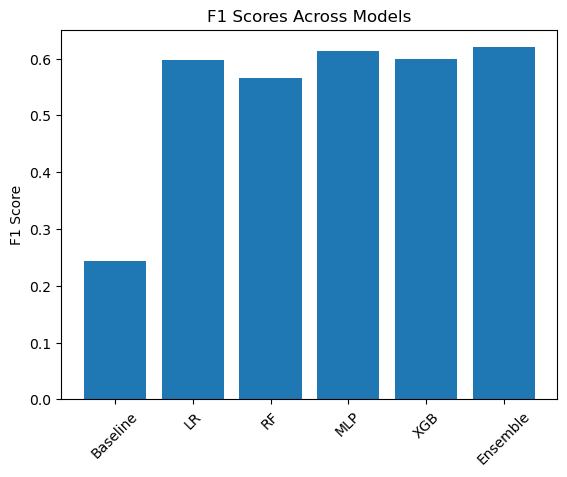

In [143]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Ensemble']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Comparison with the All-Year Models

In [145]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [146]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

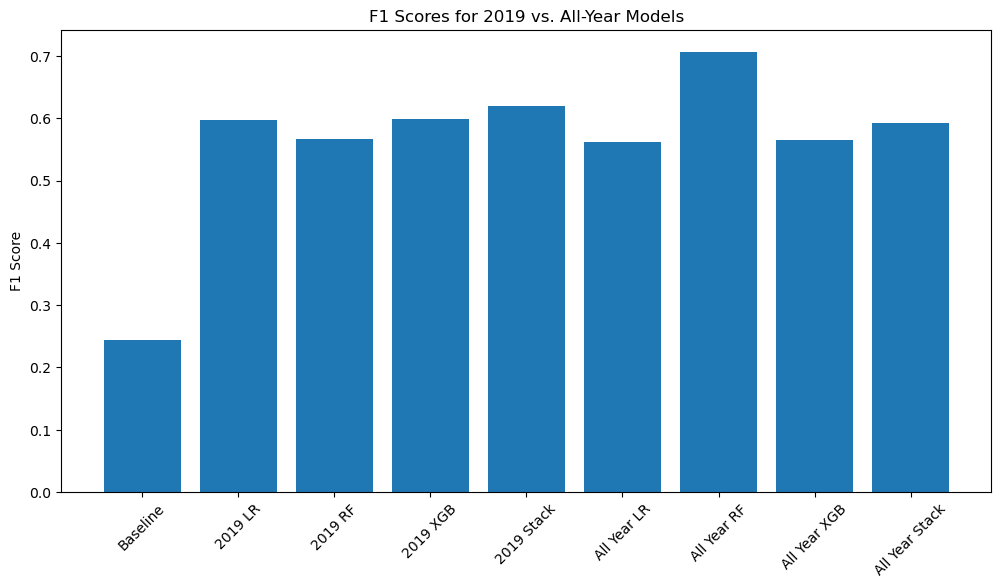

In [147]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()

## 2019 vs. Non-2019 Models

In [149]:
other_years = [y for y in range(2013, 2025) if str(y) != year]
other_years

[2013, 2014, 2015, 2016, 2017, 2018, 2020, 2021, 2022, 2023, 2024]

In [150]:
other_years_df = model_utils.load_data(other_years)
model_utils.transform_offense_date(other_years_df)
dispo_mapping = model_utils.calc_dispo_subset(other_years_df)
all_police_df.shape

(322624, 24)

In [151]:
other_years_clean = model_utils.clean_and_transform_data(other_years_df)
other_years_clean.shape

Police Calls Dataset: 3264233 rows before cleaning, 2912778 rows after cleaning.


(2912778, 15)

In [152]:
X_train_oy, X_test_oy, y_train_oy, y_test_oy, _, _, X_train_resampled_oy, y_train_resampled_oy, _ = \
    model_utils.split_data(other_years_clean, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(2330222, 14)
(582556, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Counter({3: 2237183, 0: 47361, 2: 25699, 1: 19979})
Counter({3: 93039, 0: 47361, 2: 25699, 1: 19979})


In [153]:
rf_model_oy = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model_oy.fit(X_train_oy, y_train_oy)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [154]:
y_pred_rf_oy = rf_model_oy.predict(X_test_oy)

print(f"Random Forest Other Years Classification Report for Non-{year} Data:")
print(classification_report(y_test_oy, y_pred_rf_oy, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for Non-2019 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.55      0.36      0.44     11840
Arrest by Warrant       0.70      0.54      0.61      4995
Criminal Citation       0.46      0.24      0.31      6425
            Other       0.98      0.99      0.98    559296

         accuracy                           0.97    582556
        macro avg       0.67      0.53      0.59    582556
     weighted avg       0.96      0.97      0.96    582556



In [155]:
y_pred_rf_oy_2019 = rf_model_oy.predict(X_test)

print(f"Random Forest Other Years Classification Report for {year} Data:")
print(classification_report(y_test, y_pred_rf_oy_2019, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for 2019 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.52      0.32      0.40      1309
Arrest by Warrant       0.70      0.58      0.63       573
Criminal Citation       0.49      0.20      0.29       746
            Other       0.97      0.99      0.98     54904

         accuracy                           0.96     57532
        macro avg       0.67      0.52      0.57     57532
     weighted avg       0.95      0.96      0.96     57532



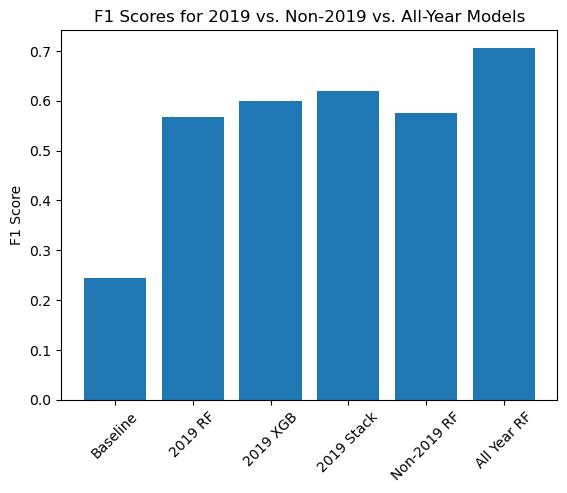

In [156]:
model_names = ['Baseline', f'{year} RF', f'{year} XGB', f'{year} Stack', f'Non-{year} RF', 'All Year RF']
f1_scores = [baseline_f1, rf_f1, xgb_1_f1, stack_2_f1, f1_score(y_test, y_pred_rf_oy_2019, average='macro'), all_yr_rf_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. Non-{year} vs. All-Year Models')
plt.show()